In [1]:
from math import log
import random
import numpy as np
import cvxpy as cp
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

In [3]:
def plot_signal(d_true, d, d_dpg, d_fpg, title, save_file):
    n = len(d_true)

    pdf = PdfPages(f'plots/2.9_{save_file}_DPG.pdf')
    
    plt.figure(figsize=(12, 3))

    plt.plot(np.arange(n), d, label='$d_{noisy}$', linewidth=0.5)
    plt.plot(np.arange(n), d_true, label='$d_{true}$', linewidth=2.5, color='red')
    plt.plot(np.arange(n), d_dpg, label='$d_{DPG}$', linewidth=2., color='black')

    plt.grid(True, linestyle='--', alpha=0.6)

    #plt.xscale('log')
    #plt.yscale('log')
    
    plt.legend(bbox_to_anchor=(1., 1.))
    
    plt.xlabel('index')
    plt.ylabel('value')

    #plt.subplots_adjust(bottom=0.24, top=0.85)
    plt.title(title)
    
    plt.subplots_adjust(left=0.08, right=0.85)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()
    
    
    
    
    
    pdf = PdfPages(f'plots/2.9_{save_file}_FDPG.pdf')
    
    plt.figure(figsize=(12, 3))

    plt.plot(np.arange(n), d, label='$d_{noisy}$', linewidth=0.5)
    plt.plot(np.arange(n), d_true, label='$d_{true}$', linewidth=2.5, color='red')
    plt.plot(np.arange(n), d_fpg, label='$d_{FDPG}$', linewidth=2., color='black')

    plt.grid(True, linestyle='--', alpha=0.6)

    #plt.xscale('log')
    #plt.yscale('log')
    
    plt.legend(bbox_to_anchor=(1., 1.))
    
    plt.xlabel('index')
    plt.ylabel('value')

    plt.subplots_adjust(left=0.08, right=0.85)
    plt.title(title)

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

### Funcitons

In [4]:
def T(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

def DPG(n, d, lambd, max_k):
    D = create_D(n)
    
    y = np.random.randn(n-1)
    
    for _ in range(max_k):
    
        x = D.T @ y + d
        y = y - (1/4) * D @ x + (1/4) * T(D @ x - 4*y, 4 * lambd)
    
    return x

def FDPG(n, d, lambd, max_k):
    D = create_D(n)
    
    y = np.zeros(n-1)
    w = y
    t = 1
    
    for _ in range(max_k):
    
        u = D.T @ w + d
        
        y_old = y
        y = w - (1/4) * D @ u + (1/4) * T(D @ u - 4 * w, 4*lambd)
        
        t_old = t
        t = (1+sqrt(1+t**2)) /  2
        
        w = y + ((t_old-1) / t) * (y - y_old)
    
    return u

### Create problem

In [5]:
def create_D(n):
    return np.eye(n - 1, n) - np.eye(n - 1, n, k=1)

In [6]:
def create_piecewise_vector(n, K, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    values = [np.random.randn(1) for _ in range(K)]
    cuts = np.sort(np.random.choice(np.arange(1, n), size=K-1, replace=False))
    parts = np.diff(np.concatenate(([0], cuts, [n])))
    x_pcw = np.repeat(values, parts)
    
    return x_pcw

In [7]:
def problem(n, noise_type, d_type, noise_scale, K=None, lambd=0.5, max_k=1000, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    
    title = f"λ = {lambd} , #steps = {max_k} , "
    
    if d_type == 'pcw':
        d_true = create_piecewise_vector(n, K)
        
    if d_type == 'smooth':
        d_true = np.sin(np.linspace(0, 2 * np.pi, n))
        
        
    title += "$d_{noisy} = d_{true} + e$ , "
        
    if noise_type == 'gaussian':
        e = noise_scale * np.random.randn(n)
        
        title += "$e \\sim \\mathcal{N}" + f"(0, {noise_scale})" + "$"
        d = d_true + e
        
    if noise_type == 'uniform':
        e = np.random.uniform(low=-noise_scale, high=noise_scale, size=n)
        
        title += "$e \\sim \\mathcal{U}" + "_{ " + f"[-{noise_scale}, {noise_scale}]" + "}" + "$"
        d = d_true + e
        
    if noise_type == 'laplace':
        e = np.random.laplace(loc=0.0, scale=noise_scale, size=n)
        d = d_true + e
        title += "$e \\sim \\mathrm{Laplace}(0, " + f"{noise_scale}" + ")$"
        
        
    save_file = f'{noise_type}_{d_type}_{noise_scale}'
    
    
    d_dpg = DPG(n, d, lambd, max_k)
    d_fpg = FDPG(n, d, lambd, max_k)
    
    
    plot_signal(d_true, d, d_dpg, d_fpg, title, save_file)

In [8]:
n = 1000

### Laplace

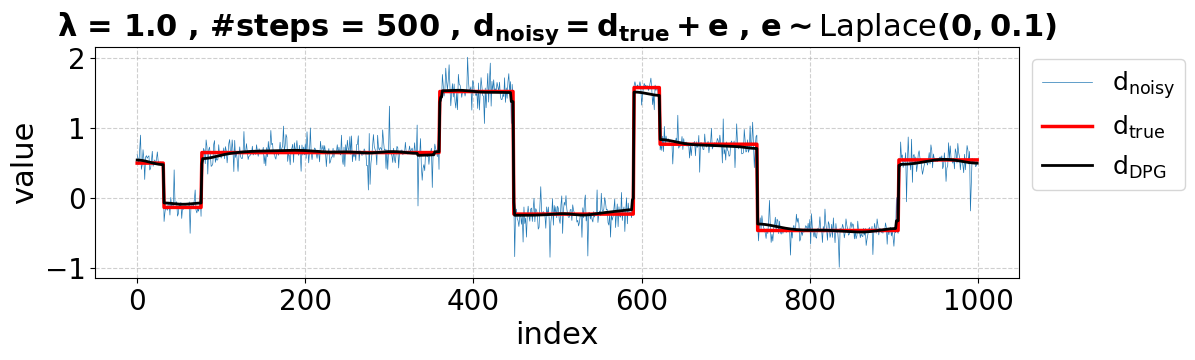

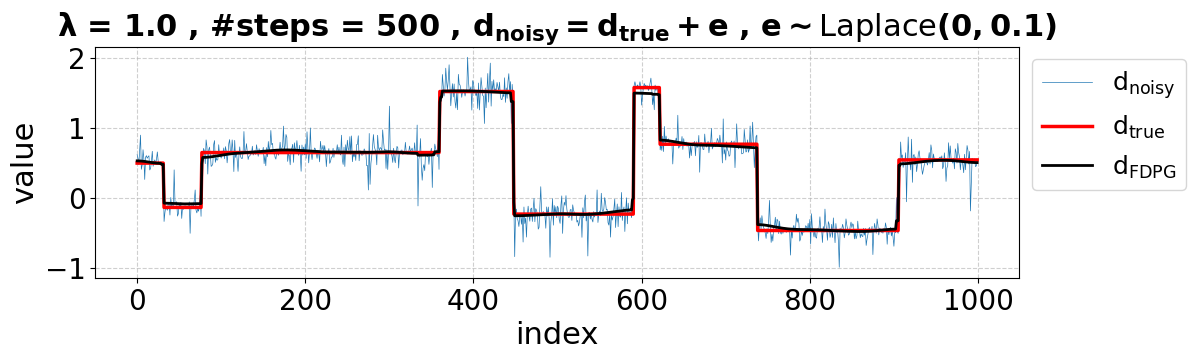

In [9]:
problem(n, 'laplace', 'pcw', 0.1, K=10, max_k=500, lambd=1.)

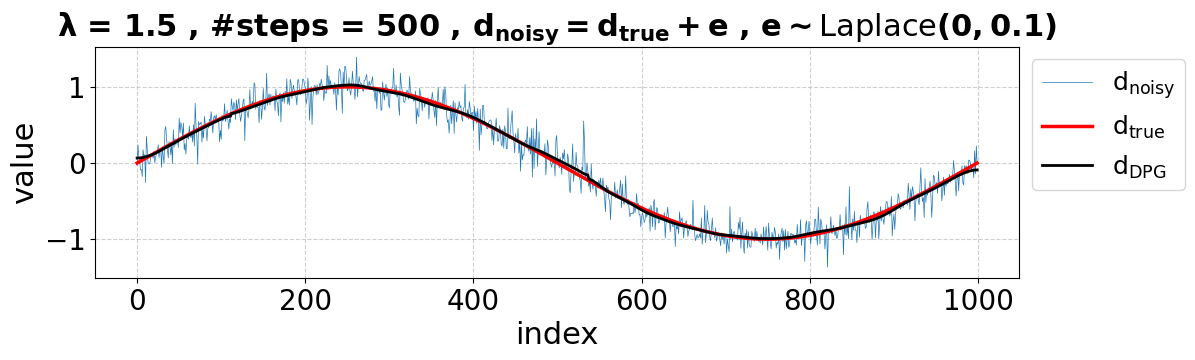

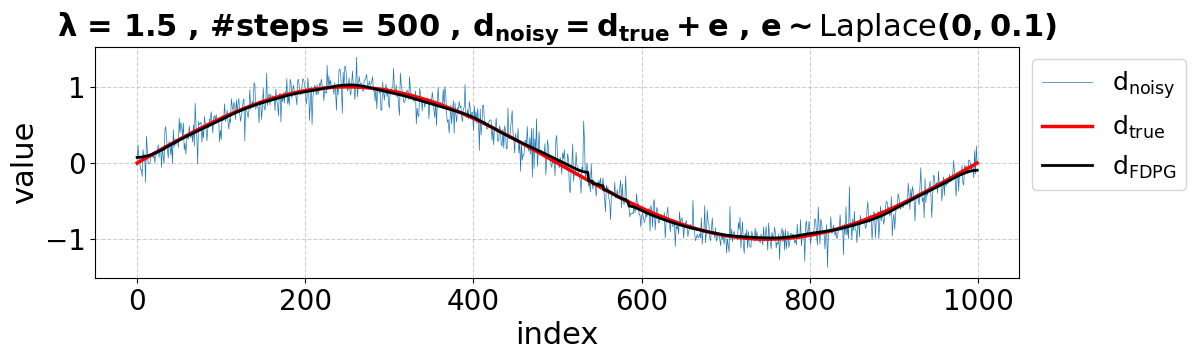

In [10]:
problem(n, 'laplace', 'smooth', 0.1, K=10, max_k=500, lambd=1.5)

### Gaussian

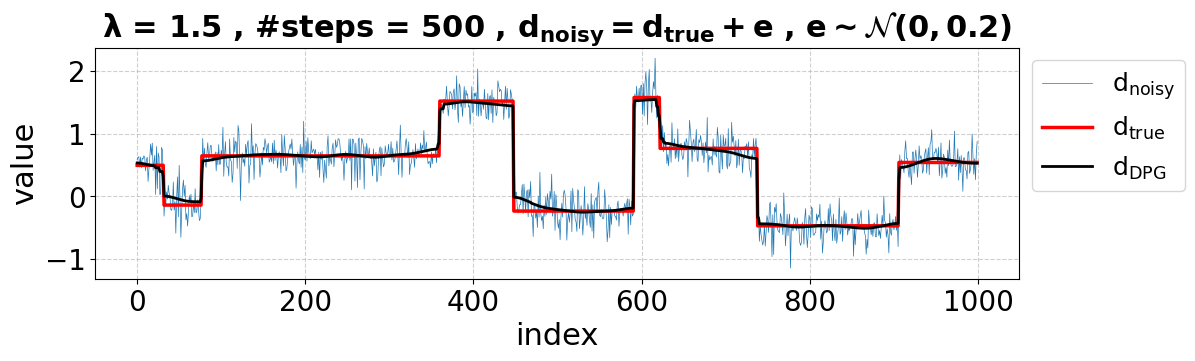

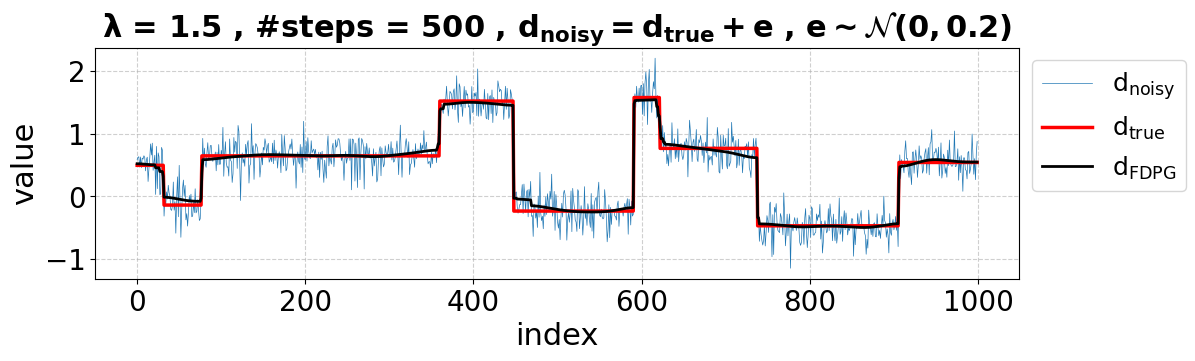

In [11]:
problem(n, 'gaussian', 'pcw', 0.2, K=10, max_k=500, lambd=1.5)

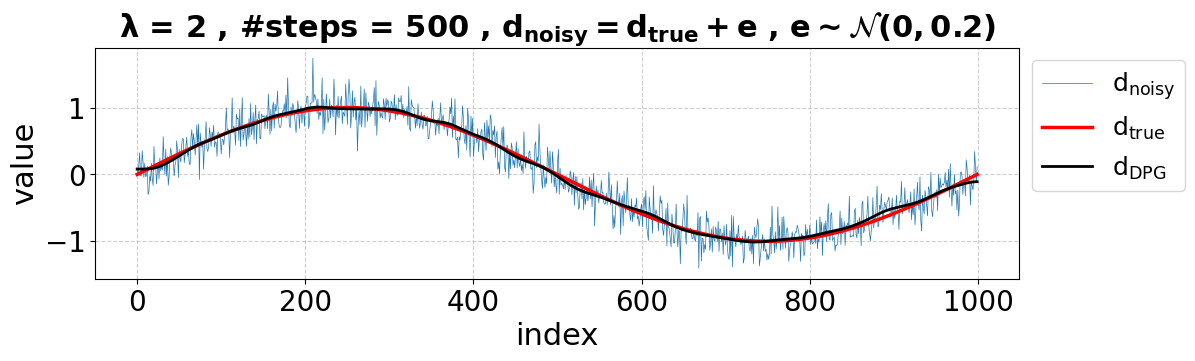

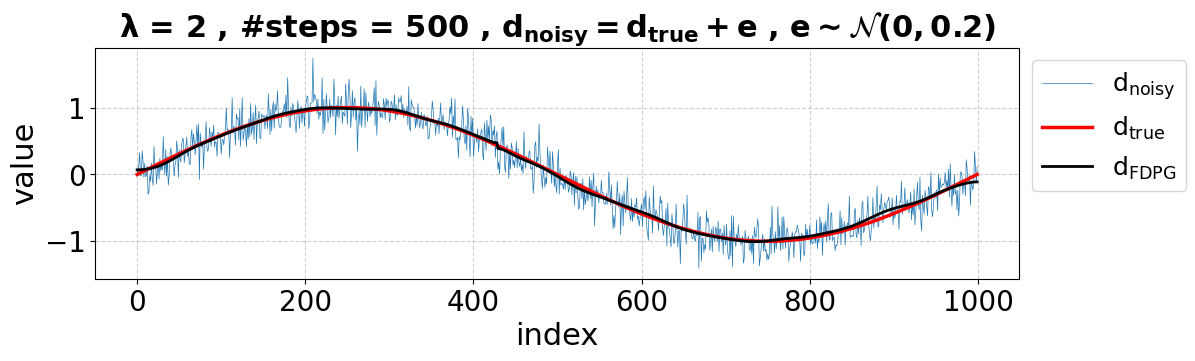

In [12]:
problem(n, 'gaussian', 'smooth', 0.2, K=10, max_k=500, lambd=2)

## Uniform

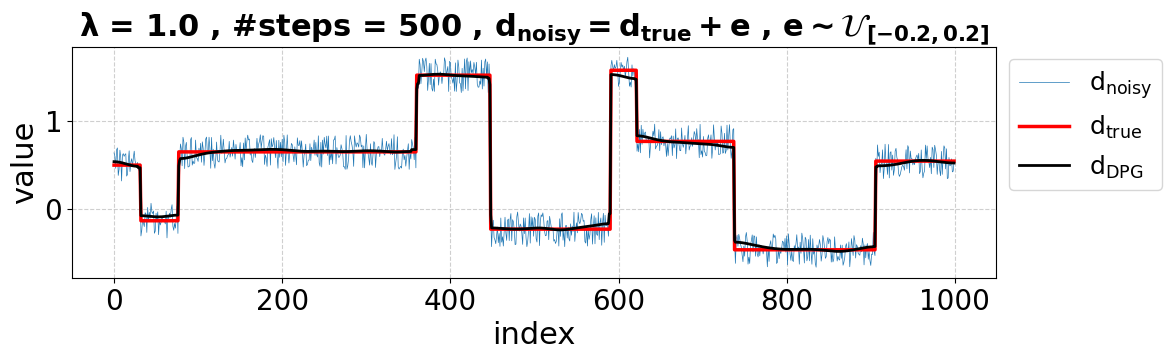

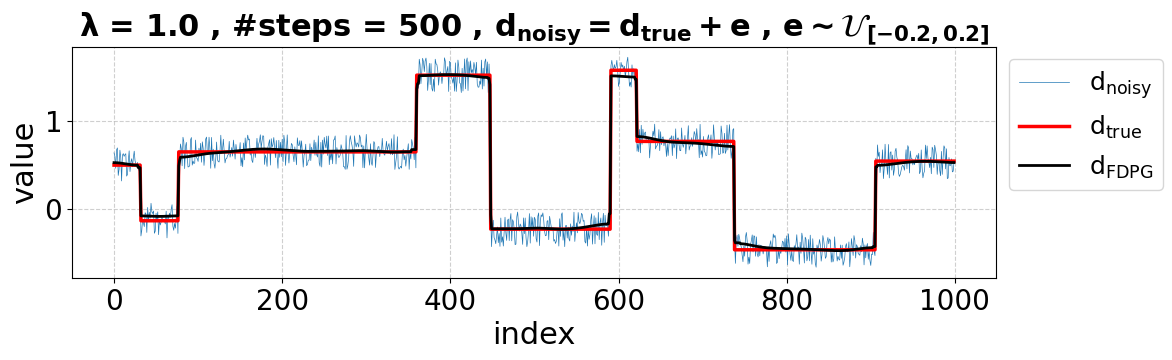

In [13]:
problem(n, 'uniform', 'pcw', 0.2, K=10, max_k=500, lambd=1.)

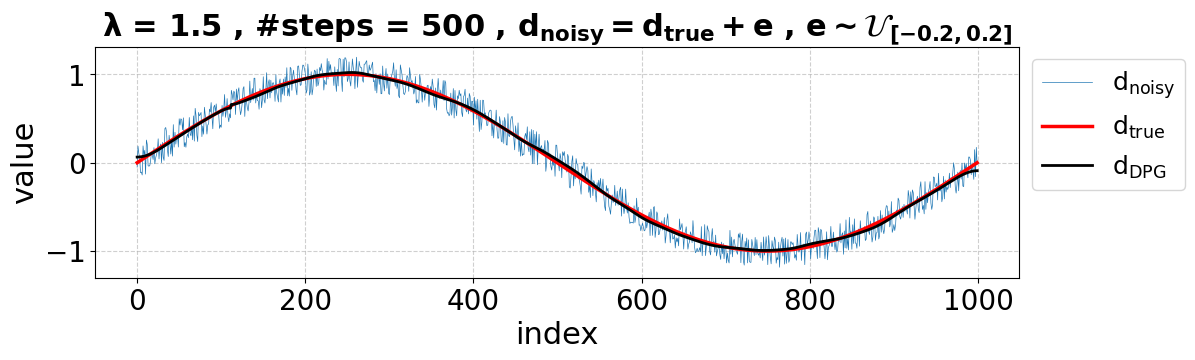

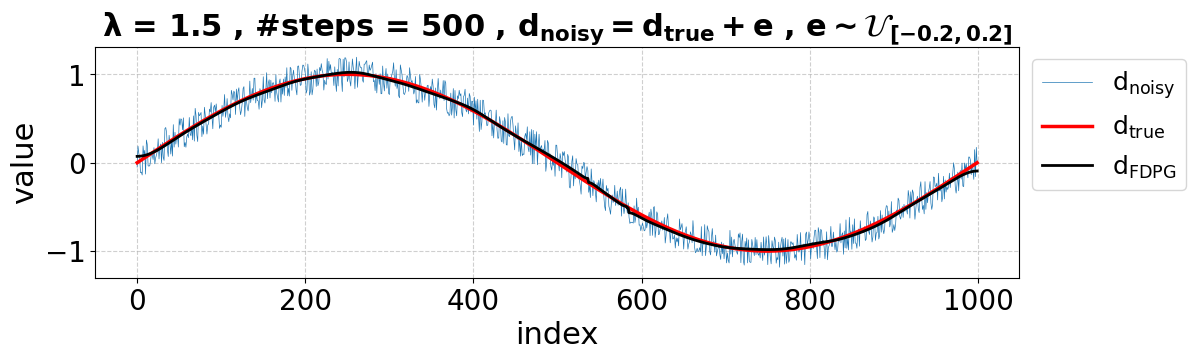

In [14]:
problem(n, 'uniform', 'smooth', 0.2, K=10, max_k=500, lambd=1.5)